## Import Libraries

In [24]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import os
import matplotlib.gridspec as gridspec
from scipy import stats
import re
import string
%matplotlib inline

In [25]:
import warnings
warnings.filterwarnings("ignore")

## Global Variables

In [26]:
data_folder_name = 'Data'
raw_data_folder_name = 'Raw_Data'
processed_data_folder_name = 'Processed_Data'
train_csv_name = 'train.csv'
test_csv_name = 'test.csv'
processed_csv_name = 'titanic_train_data_processed.csv'

## File paths

In [27]:
project_path = os.path.abspath(os.path.join(os.getcwd(),os.pardir))
data_folder = os.path.join(project_path,data_folder_name)
raw_data_path = os.path.join(data_folder,raw_data_folder_name)
processed_data_path = os.path.join(data_folder,processed_data_folder_name)
train_data_path = os.path.join(raw_data_path,train_csv_name)
test_data_path = os.path.join(raw_data_path,test_csv_name)
processed_data_path = os.path.join(processed_data_path,processed_csv_name)

## Helper Functions

In [6]:
#------------------------------------Describing---------------------------
def data_shape_summary(labels, catetogical_cols, numeric_cols):
    shape = train_data.shape 
    m = shape[0]
    n = shape[1] - 1 #n-1 because one of the columns is the desired label
    df_shape_ratio = m/n 
    print("The data has:\n", m, 'records\n', n+1, 'columns\n')

    len_labels = len(labels)
    len_cat = len(catetogical_cols)
    len_num = len(numeric_cols)
    
    labels =', '.join(labels)
    catetogical_cols = ', '.join(catetogical_cols)
    numeric_cols = ', '.join(numeric_cols)
    print("Including:\n {} label/s:\n\t{}\n {} categorical columns:\n\t{}\n {} numeric columns:\n\t{}".format(len_labels, labels, len_cat, catetogical_cols, len_num, numeric_cols))
    
   
#-------------------------------------------------------------------------
def describe_IQR(df):
    desc_df = pd.DataFrame(df.describe())
    iqr_series = desc_df.loc['75%'] - desc_df.loc['25%']
    frame = {'IQR': iqr_series}
    desc_df = desc_df.append(pd.DataFrame(frame).T)
    
    min_thresh = desc_df.loc['25%'] - 1.5*desc_df.loc['IQR']
    max_thresh = desc_df.loc['75%'] + 1.5*desc_df.loc['IQR']

    frame = {'min_IQR_thresh':min_thresh, 'max_IQR_thresh':max_thresh}
    desc_df = desc_df.append(pd.DataFrame(frame).T)

    return desc_df
#---------------------------------------------------------------
def unique_identifiers(train_data):
    dic = dict()

    for column in train_data.columns:
        column_uniqueness = train_data[column].nunique()
        dic[column] =column_uniqueness

    uniques_df = pd.DataFrame(pd.Series(dic).sort_values(ascending=False), columns={'#unique'})
    uniques_df['%unique'] = round((uniques_df['#unique']/m)*100,2)
    uniques_df['unique_identifier_flag'] = uniques_df['%unique'].apply(lambda x:'Y' if x==100.00 else 'N')
    return uniques_df
#---------------------------------------------------------------
def numeric_desc(df):  #what is density?
    df = df.select_dtypes(include=[np.number])
    unique_identifier_cols = df.columns[df.columns.isin(unique_identifiers)]
    NoNunique_identifier_cols = df.columns[~df.columns.isin(unique_identifiers)]
    desc = pd.DataFrame()
    desc['Type'] = df.dtypes
    desc['Density'] = np.nan
    desc['No. of Values'] = df.count()
    desc['No. of Unique Values'] = df.nunique(dropna=False) # taking nans into consideration
    desc['No. of NaN'] = df.apply(np.isnan, axis=1).sum()
    desc['No. of Zeros'] = len(df)- np.count_nonzero(df, axis=0)
    desc['No. of +ve Values'] = df.apply(lambda x: x>0).sum()
    desc['Min'] = df.min()
    desc['Max'] = df.max()
    desc['Mean'] = df.mean()
    desc['Std'] = df.std()
    desc['Median'] = df.median(skipna=False) # taking nans into consideration  this is the part that can be parametertized
    desc['Mode'] = df[NoNunique_identifier_cols].mode().T #remove the columns that have 100% uniqueness
    desc['Skew'] = df.skew()
    desc['Kurtosis'] = df.kurtosis() #-ve >> left tailed dist // +ve >> right tailed //0 >>normal dist
    desc['No. of 3 Sigma Outliers'] = (np.abs(stats.zscore(df,nan_policy='omit')) > 3).sum(axis=0) #omitting nans to match describe2
    return desc
#---------------------------------------------------------------
def object_desc(df):  #what is density?
    df = df.select_dtypes(include=[np.object])
    desc = pd.DataFrame(index=df.columns)
    desc['Type'] = df.dtypes
    desc['Density'] = np.nan
    desc['No. of Values'] = df.count() #non na values
    desc['No. of Unique Values'] = df.nunique(dropna=False) # taking nans into consideration
    desc['No. of NaN'] = df.isnull().sum()
    return desc

def desc(df):
    nums =  numeric_desc(df)
    obj =   object_desc(df)
    return nums,obj  
#---------------------------------------------------------------
#------------------------------------Plotting---------------------------
#---------------------------------------------------------------
def colors_list(unique_list):
    length = len(unique_list)
    colors_list = ['orange']
    colors_list.extend(['blue']*(length-1))
    return colors_list

#---------------------------------------------------------------

def colors_list_sorted(train_data_copy,var_name,var_unique_list):
    train_data_copy = train_data_copy.set_index(var_name)
    means_index_sorted = pd.DataFrame(train_data_copy.groupby(level=0)['Survived'].mean()).sort_values(by='Survived',ascending=False)
    colors_listed = colors_list(var_unique_list)
    colors_df = pd.DataFrame(index = means_index_sorted.index, data= {'colors': colors_listed})
    colors_df = colors_df.sort_index()
    return list(colors_df.sort_index()['colors'])

#---------------------------------------------------------------

def variable_mean_survival(var_name):
    train_data_copy = train_data[~train_data[var_name].isna()]
    train_data_copy['Survived'] =  train_data_copy['Survived'].astype(int)
    if train_data_copy[var_name].dtype.name != 'category':
        var_unique_list = sorted(list(train_data_copy[var_name].unique())) 
    else:
        var_unique_list = list(train_data[var_name].dtype.categories)
    countPerVarValue = pd.DataFrame(train_data_copy.groupby(var_name)['PassengerId'].count(),index = var_unique_list)['PassengerId'] 
    avg_survival = pd.DataFrame(train_data_copy.set_index(var_name).groupby(level=0)['Survived'].mean(),index = var_unique_list)['Survived']

    colors_map = colors_list_sorted(train_data_copy,var_name,var_unique_list)
                                      
    return var_unique_list, countPerVarValue, avg_survival, colors_map

#---------------------------------------------------------------

def variable_mean_survival_sorted_survival(var_name):
    train_data_copy = train_data[~train_data[var_name].isna()]
    train_data_copy['Survived'] =  train_data_copy['Survived'].astype(int)
    var_unique_list = sorted(list(train_data_copy[var_name].unique())) 

    countPerVarValue = pd.DataFrame(train_data_copy.groupby(var_name)['PassengerId'].count(),index = var_unique_list)['PassengerId'] 
    avg_survival = pd.DataFrame(train_data_copy.set_index(var_name).groupby(level=0)['Survived'].mean(),index = var_unique_list)['Survived']
    avg_survival = round(avg_survival,2)
    colors_map = colors_list_sorted(train_data_copy,var_name,var_unique_list)
    
    df = pd.concat([countPerVarValue,avg_survival], axis=1).rename(columns={'PassengerId':'countPerVarValue','Survived':'avg_survival'}).sort_values(by='avg_survival')

    return df

#---------------------------------------------------------------

def variable_mean_survival_subset(df,var_name):
    train_data_copy = df[~train_data[var_name].isna()]
    train_data_copy['Survived'] =  train_data_copy['Survived'].astype(int)
    var_unique_list = sorted(list(train_data_copy[var_name].unique()))     
    countPerVarValue = pd.DataFrame(train_data_copy.groupby(var_name)['PassengerId'].count(),index = var_unique_list)['PassengerId'] 
    avg_survival = pd.DataFrame(train_data_copy.set_index(var_name).groupby(level=0)['Survived'].mean(),index = var_unique_list)['Survived']

    colors_map = colors_list_sorted(train_data_copy,var_name,var_unique_list)
                                      
    return var_unique_list, countPerVarValue, avg_survival, colors_map

#---------------------------------------------------------------

def plt_settings(cur_plt, ititle):
    ax = cur_plt.gca()
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
    ax.tick_params(axis=u'both', which=u'both',length=0)
    #ax.get_yaxis().set_visible(False)  
    ax.set_yticklabels([])
    plt.title(ititle)
    for i, rect in enumerate(ax.patches):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height,  str(round(height, 2)),
                ha='center', va='bottom')  
#---------------------------------------------------------------

def plt_simple_settings(cur_plt, ititle):
    ax = cur_plt.gca()
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
    ax.tick_params(axis=u'both', which=u'both',length=0)
    #ax.get_yaxis().set_visible(False)  
    #ax.set_yticklabels([])
    plt.title(ititle)
    #for i, rect in enumerate(ax.patches):
     #   height = rect.get_height()
     #   ax.text(rect.get_x() + rect.get_width() / 2, height,  str(round(height, 2)),
     #           ha='center', va='bottom')        

#---------------------------------------------------------------

def remove_top_right_spines(cur_plt):
    ax = cur_plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
#---------------------------------------------------------------

def setup_legends(colors_dict, plt):
    labels = list(colors_dict.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors_dict[label]) for label in labels]
    plt.subplot(1, 3, 2)
    plt_settings(plt,'')
    plt.gca().get_xaxis().set_visible(False)  
    plt.legend(handles, labels);   
    
    
    

## Loading the data

In [28]:
raw_data_train = pd.read_csv(train_data_path)

train_data = raw_data_train.copy()

# Exploratory Data Analysis

In [68]:
labels = ['Survived']
catetogical_cols = ['Survived', 'Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
numeric_cols = ['PassengerId',  'Age', 'SibSp', 'Parch','Fare']
 
data_shape_summary(labels, catetogical_cols, numeric_cols)    

The data has:
 891 records
 12 columns

Including:
 1 label/s:
	Survived
 7 categorical columns:
	Survived, Pclass, Name, Sex, Ticket, Cabin, Embarked
 5 numeric columns:
	PassengerId, Age, SibSp, Parch, Fare


### full row duplicates

In [8]:
cnt_full_row_dup = sum(train_data.duplicated())
print("The data has ",cnt_full_row_dup, 'Full Row Duplications')

The data has  0 Full Row Duplications


### shape of data

In [10]:
shape = train_data.shape 
m = shape[0]
n = shape[1] - 1 #n-1 because one of the columns is the desired label
df_shape_ratio = m/n 
print("The data has:\n", m, 'records\n', n, 'features\n 1 label')

The data has:
 891 records
 11 features
 1 label


### nulls in data

In [11]:
#print statements for nulls : >20% - <30% nulls, 30%-50%  , >50%
nulls_df = pd.DataFrame((train_data.isnull().sum()).sort_values(ascending=False), columns={'#nulls'})
nulls_df['%nulls'] = (nulls_df['#nulls']/m*100)
nulls_df

,#nulls,%nulls
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


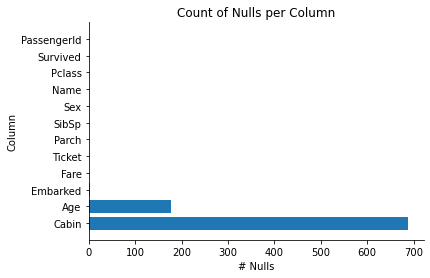

In [13]:
plt.figure()   ## this should plot %nulls not #nulls
plt.barh(nulls_df.index, width=nulls_df['#nulls'])
remove_top_right_spines(plt)
plt.title('Count of Nulls per Column');
plt.ylabel('Column')
plt.xlabel('# Nulls');

### uniqueness of data

In [22]:
#debug unique_identifiers fn
#unique_identifiers fn should return the df and the names of the 100% and 0 % uniqueness
uniques_df = unique_identifiers(train_data)
uniques_df 

TypeError: 'list' object is not callable

In [20]:
unique_identifiers= list(uniques_df[uniques_df['unique_identifier_flag']=='Y'].index)
print('The columns that can be used to uniquely identify records are:\n {} , {} '.format(unique_identifiers[0],unique_identifiers[1]))

The columns that can be used to uniquely identify records are:
 Name , PassengerId 


## Label Identification

In [16]:
# turn label into print statement and features as well
lable = ['Survived']

non_lable = train_data.columns[~train_data.columns.isin(lable)]

## Fix columns data types
some columns are numerical when they should be str or categorical

In [17]:
train_data['Pclass'] = train_data['Pclass'].astype('str')
train_data['Survived'] = train_data['Survived'].astype('str')

## Describe

In [18]:
desc_df = describe_IQR(train_data)
desc_df

,PassengerId,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,29.699118,0.523008,0.381594,32.204208
std,257.353842,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,38.000000,1.000000,0.000000,31.000000
max,891.000000,80.000000,8.000000,6.000000,512.329200
IQR,445.000000,17.875000,1.000000,0.000000,23.089600
min_IQR_thresh,-444.000000,-6.687500,-1.500000,0.000000,-26.724000


In [19]:
#use IQR instead of 3 sigma in descibe functions (default for outliers detection is IQR)
#draw histigram for these vars and relate to the kurtosis/skew col (other notebook)
numeric_desc_df = desc(train_data)[0]  
numeric_desc_df

,Type,Density,No. of Values,No. of Unique Values,No. of NaN,No. of Zeros,No. of +ve Values,Min,Max,Mean,Std,Median,Mode,Skew,Kurtosis,No. of 3 Sigma Outliers
PassengerId,int64,NaN,891,891,0,0,891,1.00,891.0000,446.000000,257.353842,446.0000,NaN,0.000000,-1.200000,0
Age,float64,NaN,714,89,177,0,714,0.42,80.0000,29.699118,14.526497,NaN,24.00,0.389108,0.178274,2
SibSp,int64,NaN,891,7,0,608,283,0.00,8.0000,0.523008,1.102743,0.0000,0.00,3.695352,17.880420,30
Parch,int64,NaN,891,7,0,678,213,0.00,6.0000,0.381594,0.806057,0.0000,0.00,2.749117,9.778125,15
Fare,float64,NaN,891,248,0,15,876,0.00,512.3292,32.204208,49.693429,14.4542,8.05,4.787317,33.398141,20


In [20]:
cat_desc_df = desc(train_data)[1]  
cat_desc_df

,Type,Density,No. of Values,No. of Unique Values,No. of NaN
Survived,object,NaN,891,2,0
Pclass,object,NaN,891,3,0
Name,object,NaN,891,891,0
Sex,object,NaN,891,2,0
Ticket,object,NaN,891,681,0
Cabin,object,NaN,204,148,687
Embarked,object,NaN,889,4,2


## IQR Outliers

In [21]:
IQR_outliers_df = pd.DataFrame((train_data<desc_df.loc['min_IQR_thresh']).sum() + (train_data>desc_df.loc['max_IQR_thresh']).sum(), columns={'#Outliers'} )
IQR_outliers_df['%Outliers'] = round((IQR_outliers_df['#Outliers']/m*100),2)
IQR_outliers_df

,#Outliers,%Outliers
Age,11,1.23
Cabin,0,0.00
Embarked,0,0.00
Fare,116,13.02
Name,0,0.00
Parch,213,23.91
PassengerId,0,0.00
Pclass,0,0.00
Sex,0,0.00
SibSp,46,5.16


# Data Variables Vs Survival

## What is the relation between Gender and Survival?

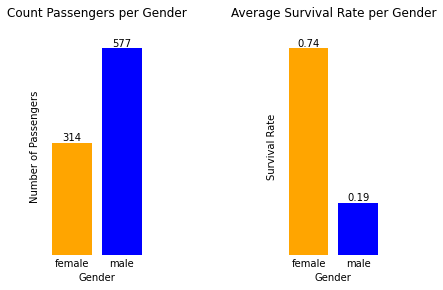

In [80]:
unique_sexes,sex_value_count, avg_survival,colors_map = variable_mean_survival('Sex')
fig = plt.figure()

plt.subplot(1, 3, 1)
plt.bar(unique_sexes,sex_value_count,color=colors_map)
plt_settings(plt,'Count Passengers per Gender\n')
plt.xlabel('Gender')
plt.ylabel('Number of Passengers')

plt.subplot(1, 3, 3)
plt.bar(unique_sexes,avg_survival,color=colors_map)
plt_settings(plt,'Average Survival Rate per Gender\n')
plt.xlabel('Gender')
plt.ylabel('Survival Rate');

### What is the relation between Passenger's Class and Survival?

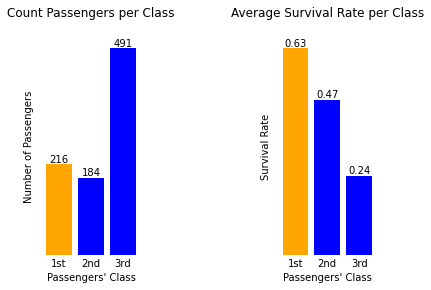

In [81]:
unique_class,class_value_count, avg_survival,colors_map = variable_mean_survival('Pclass')

plt.subplot(1, 3, 1)
plt.bar(unique_class,class_value_count,color=colors_map)
plt_settings(plt,'Count Passengers per Class\n')
plt.xticks(ticks=['1','2','3'],labels= ['1st','2nd', '3rd']);
plt.xlabel("Passengers' Class")
plt.ylabel('Number of Passengers')

plt.subplot(1, 3, 3)
plt.bar(unique_class,avg_survival,color=colors_map)
plt_settings(plt,'Average Survival Rate per Class\n')
plt.xticks(ticks=['1','2','3'],labels= ['1st','2nd', '3rd']);
plt.xlabel("Passengers' Class")
plt.ylabel('Survival Rate');

## What is the relation between boarding station and survival? 

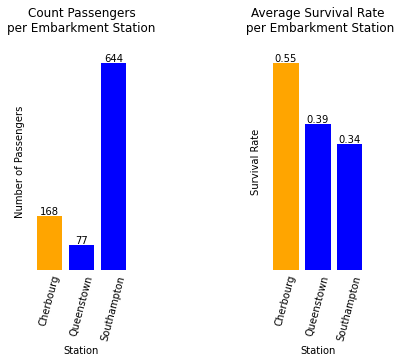

In [23]:
unique_embark,embark_value_count, avg_survival,colors_map = variable_mean_survival('Embarked')
plt.subplot(1, 3, 1)
plt.bar(unique_embark,embark_value_count,color=colors_map)
plt_settings(plt,'Count Passengers\nper Embarkment Station\n')
plt.xticks(ticks=['C','Q','S'],labels= ['Cherbourg','Queenstown', 'Southampton'], rotation = 75);
plt.xlabel('Station')
plt.ylabel('Number of Passengers')

plt.subplot(1, 3, 3)
plt.bar(unique_embark,avg_survival,color=colors_map)
plt_settings(plt,'Average Survival Rate\n per Embarkment Station\n')
plt.xticks(ticks=['C','Q','S'],labels= ['Cherbourg','Queenstown', 'Southampton'], rotation = 75);
plt.xlabel('Station')
plt.ylabel('Survival Rate');

### What is the nature of passengers who embarked from Cherbourg? (Pclass & Gender)

Passengers from Cherbourg were predominantly First Class
 which explains why they have higher survival chances as we will see Later


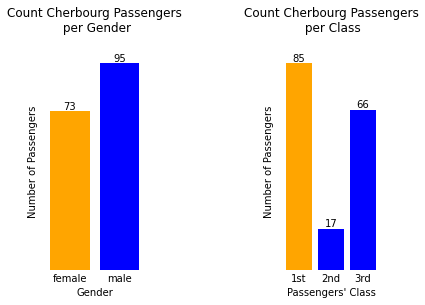

In [24]:
c_df = train_data[train_data['Embarked'] == 'C'][['PassengerId','Sex', 'Pclass', 'Survived']]
unique_sex,sex_value_count, avg_survival,colors_map = variable_mean_survival_subset(c_df,'Sex')

plt.subplot(1, 3, 1)
plt.bar(unique_sex,sex_value_count,color=colors_map)
plt_settings(plt,'Count Cherbourg Passengers\n per Gender\n')
plt.xlabel('Gender')
plt.ylabel('Number of Passengers');

unique_class,class_value_count, avg_survival,colors_map = variable_mean_survival_subset(c_df,'Pclass')
plt.subplot(1, 3, 3)
plt.bar(unique_class,class_value_count,color=colors_map)
plt_settings(plt,'Count Cherbourg Passengers\n per Class\n')
plt.xticks(ticks=['1','2','3'],labels= ['1st','2nd', '3rd']);
plt.xlabel("Passengers' Class")
plt.ylabel('Number of Passengers');

print('\033[1m'+'Passengers from Cherbourg were predominantly First Class\n which explains why they have higher survival chances as we will see Later'+'\033[1m')

## What is the relation between the Passenger's travel company size and Survival?
We will analyse siblings, spouses, children, and parents travelling with the passenger

Combine SibSp and Parch in one column indicating size of travel company

In [26]:
def family_flag(x):
    sum_all =  x['SibSp'] + x['Parch']
    if sum_all == 0 :
        return 'Alone'
    elif sum_all < 4:
        return 'Small Family'
    else:
        return 'Big Family'

In [27]:
train_data['Family_flag']  = train_data.apply(family_flag, axis=1)

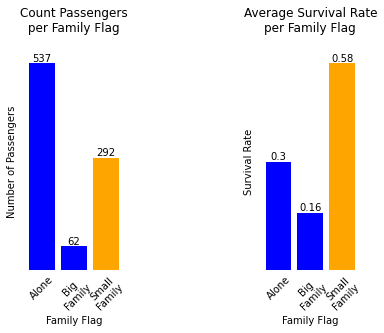

In [28]:
# reorder the x axsis
unique_famFlag,famFlag_value_count, avg_survival,colors_map = variable_mean_survival('Family_flag')

plt.subplot(1,3,1) 
plt.bar(list(map(str,unique_famFlag)), famFlag_value_count, color=colors_map)
plt_settings(plt,'Count Passengers\n per Family Flag \n')
plt.xticks(ticks=[0,1,2],labels=['Alone','Big\nFamily', 'Small\nFamily'],  rotation = 45);
plt.xlabel("Family Size")
plt.ylabel('Number of Passengers')

plt.subplot(1, 3, 3)
plt.bar(list(map(str,unique_famFlag)),avg_survival,color=colors_map)
plt_settings(plt,'Average Survival Rate\nper Family Flag\n')
plt.xticks(ticks=[0,1,2],labels=['Alone','Big\nFamily', 'Small\nFamily'],  rotation = 45);
plt.xlabel("Family Size")
plt.ylabel('Survival Rate');

## What is the relation between Passengers' Age and Survival?

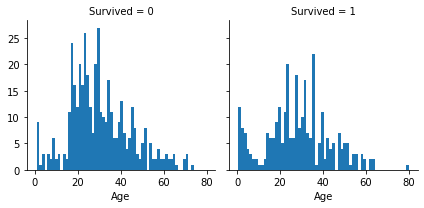

In [29]:
g = sns.FacetGrid(train_data, col='Survived')
g.map(plt.hist, 'Age', bins=60)

### What is the relation between age group and survival?

In [30]:
#sort the ages into age groups #explore more about binning!
bins = [0, 2, 12, 17, 60, np.inf]
labels = ['baby', 'child', 'teenager', 'adult', 'elderly']
age_groups = pd.cut(train_data.Age, bins, labels = labels)
train_data['Age_Group'] = age_groups

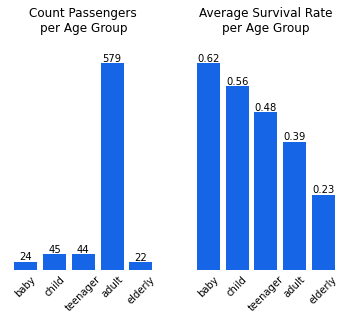

In [31]:
unique_ageGroup,ageGroup_value_count, avg_survival,colors_map = variable_mean_survival('Age_Group')

plt.subplot(1,2,1) 
plt.bar(unique_ageGroup, ageGroup_value_count, color='#1565e6') #'#0948ad'
plt_settings(plt,'Count Passengers\nper Age Group\n')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(unique_ageGroup,avg_survival,color='#1565e6')
plt_settings(plt,'Average Survival Rate\nper Age Group\n')
plt.xticks(rotation=45);

### What are the chances of survival of children with parents vs without parents?

No babies were travelling alone without parents


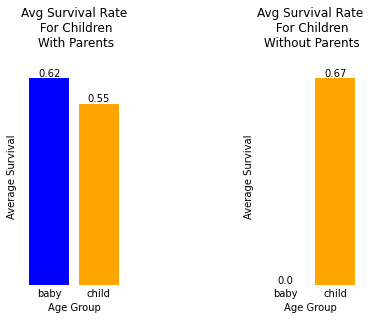

In [32]:
#baby with/without parents  . children with/without parents  .. will showcase n there r 0 babies travelling without parents
# so in plotting I will only plot children with vs children without
df = train_data[train_data['Age_Group'].isin(['baby','child'])]
unique_vals = df['Age_Group'].unique()

df['Survived'] = df['Survived'].astype(int)
df_zeroParents = df[df['Parch']==0]
df_withParents = df[df['Parch']>0]

zeroParents_avg_survival = pd.DataFrame(df_zeroParents.set_index('Age_Group').groupby(level=0)['Survived'].mean(),index = unique_vals)['Survived']
zeroParents_avg_survival = zeroParents_avg_survival.apply(lambda x: 0 if pd.isnull(x) else x)

withParents_avg_survival = pd.DataFrame(df_withParents.set_index('Age_Group').groupby(level=0)['Survived'].mean(),index = unique_vals)['Survived']

plt.subplot(1,3,1) 
plt.bar(unique_vals, withParents_avg_survival, color=['blue','orange'])
plt_settings(plt,'Avg Survival Rate\n For Children\n With Parents\n')
plt.xlabel('Age Group')
plt.ylabel('Average Survival')

plt.subplot(1,3,3) 
plt.bar(unique_vals, zeroParents_avg_survival, color=['blue','orange'])
plt_settings(plt,'Avg Survival Rate\n For Children\n Without Parents\n')
plt.xlabel('Age Group')
plt.ylabel('Average Survival');

print('\033[1m'+'No babies were travelling alone without parents'+'\033[1m')

### What are the chances of survival of adults with childen vs without children?

In [23]:
#this can be skipped
df = train_data[train_data['Age_Group'].isin(['adult'])]
unique_vals = df['Age_Group'].unique()

df['Survived'] = df['Survived'].astype(int)
df_zeroCh = df[df['Parch']==0]
df_withCh = df[df['Parch']>0]

zeroCh_avg_survival = pd.DataFrame(df_zeroCh.set_index('Age_Group').groupby(level=0)['Survived'].mean(),index = unique_vals)['Survived']

withCh_avg_survival = pd.DataFrame(df_withCh.set_index('Age_Group').groupby(level=0)['Survived'].mean(),index = unique_vals)['Survived']

labels = ['adults \nwith children','adults\n without children']
avg_surv = [withCh_avg_survival.values[0],zeroCh_avg_survival.values[0]]
plt.subplot(1,2,1) 
plt.bar(labels, avg_surv, color=['orange','blue'])
plt_settings(plt,'Avg Survival Rate\n For Adults\n With/without Children\n')
plt.xlabel('Age Group')
plt.ylabel('Average Survival');


KeyError: 'Age_Group'

### What is the relationship between Age and Class?

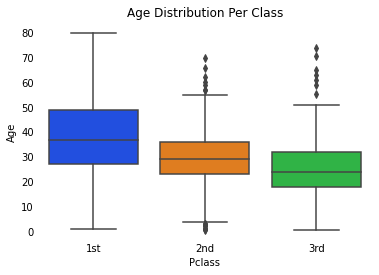

In [34]:
baby = train_data[train_data['Age_Group']=='baby']
child = train_data[train_data['Age_Group']=='child']
teenager = train_data[train_data['Age_Group']=='teenager']
adults = train_data[train_data['Age_Group']=='adult']
elderly = train_data[train_data['Age_Group']=='elderly']

sns.boxplot(x='Pclass',y='Age',data=train_data.sort_values(by='Pclass'), palette='bright')

plt_simple_settings(plt,'Age Distribution Per Class')
plt.yticks();
plt.xticks(ticks=[0,1,2], labels=['1st', '2nd','3rd']);

## What is the relationship between Cabin and Survival?

- Following the idea that passengers of no cabin stated are of lower classes
- Note: Cabins column is 77% nulls making it difficult to be a reliable source of analysis

In [35]:
train_data['Cabin_Flag'] = train_data["Cabin"].notnull().astype(int).map({0: 'unkown cabin', 1: 'known cabin'})


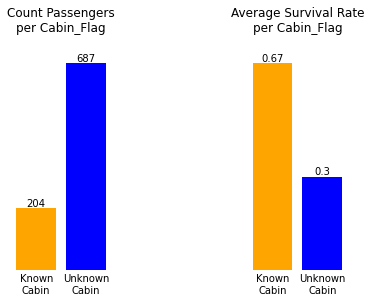

In [36]:
unique_cabinFlag,cabinFlag_value_count, avg_survival,colors_map = variable_mean_survival('Cabin_Flag')

plt.subplot(1,3,1) 
plt.bar(unique_cabinFlag, cabinFlag_value_count, color=colors_map)
plt_settings(plt,'Count Passengers\nper Cabin_Flag\n')
plt.xticks(ticks=[0,1],labels=['Known\nCabin', 'Unknown\nCabin'])

plt.subplot(1, 3, 3)
plt.bar(unique_cabinFlag,avg_survival,color=colors_map)
plt_settings(plt,'Average Survival Rate\nper Cabin_Flag\n')
plt.xticks(ticks=[0,1],labels=['Known\nCabin', 'Unknown\nCabin']);
 

### What are the characteristics of passengers with known Vs unkown Cabins?
#since class and gender are 2 strong predictors, can they be attributed to the observation that pple with known cabins having higher survival rates?

#### Passenger Class relative to known Vs Unknown Cabins

In [37]:
train_data['Survived'] = train_data['Survived'].astype(int)
unique_vals = train_data['Cabin_Flag'].unique()

known_cabins_df = train_data[train_data['Cabin_Flag']=='known cabin']
unknown_cabins_df = train_data[train_data['Cabin_Flag']=='unkown cabin']

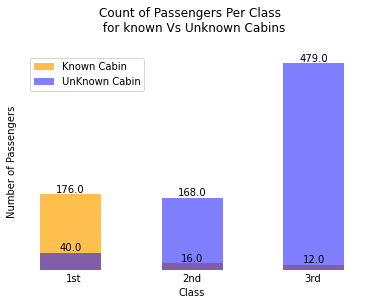

In [38]:
#add 3rd color to legend for overlap
plt.hist(known_cabins_df['Pclass'].sort_values(), alpha=0.7, color ='orange',label='Known Cabin',bins=3,rwidth=0.5);
plt.hist(unknown_cabins_df['Pclass'].sort_values(), alpha=0.5,color ='blue', label='UnKnown Cabin',bins=3,rwidth=0.5);
plt.legend();
plt.xticks(ticks=[0.35,1,1.66], labels=['1st','2nd','3rd']);

plt_settings(plt, 'Count of Passengers Per Class \n for known Vs Unknown Cabins\n')
plt.xlabel('Class')
plt.ylabel('Number of Passengers');

#### Gender  relative to known Vs Unknown Cabins

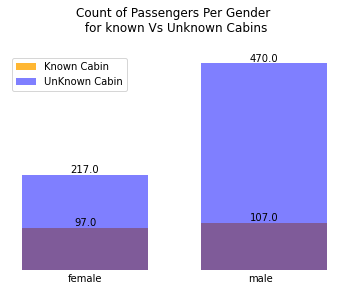

In [39]:
#can add statemnt that gender doesnot seem to explain

plt.hist(known_cabins_df['Sex'].sort_values(), alpha=0.8, color ='orange',label='Known Cabin', bins=2, rwidth=0.7);
plt.hist(unknown_cabins_df['Sex'].sort_values(), alpha=0.5,color ='blue', label='UnKnown Cabin',bins=2, rwidth=0.7);
plt.legend();
plt.xticks(ticks=[0.25,0.74], labels=['female','male']);

plt_settings(plt, 'Count of Passengers Per Gender \n for known Vs Unknown Cabins\n')

### Cabin Category
- Cabins are 77% nulls so we will leave Category 'N' to represent unkown cabins
- According to [this link](https://www.encyclopedia-titanica.org/cabins.html) it seems that different cabin categories are associated with more than just one class

In [59]:
train_data['Cabin_Cat'] = train_data['Cabin'].apply(lambda x:str(x)[0].upper())

In [60]:
df = pd.DataFrame(train_data.groupby('Cabin_Cat')['Pclass'].unique())
df['Pclass'] = [','.join(map(str, l)) for l in df['Pclass']]
df

,Pclass
Cabin_Cat,
A,1
B,1
C,1
D,"2,1"
E,"1,2,3"
F,"2,3"
G,3
N,"3,2,1"
T,1


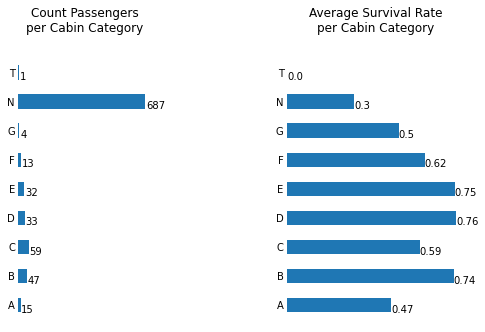

In [61]:
#can categorize these into 3 categories divide into 3 geneal cats
unique_cabinCat,cabinCat_value_count, avg_survival,colors_map = variable_mean_survival('Cabin_Cat')

plt.figure(figsize=(8,5))
gspec = gridspec.GridSpec(24, 50)

plot1 = plt.subplot(gspec[:, :15])
plot1.barh(unique_cabinCat, cabinCat_value_count, height = 0.5)
ax = plt.gca()
for spine in ax.spines:
    ax.spines[spine].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.get_xaxis().set_visible(False)  
plt.title('Count Passengers\nper Cabin Category\n');
for i, rect in enumerate(ax.patches):
    v =  rect.get_y()
    ax.text( v + rect.get_width(), i-.25 , str(rect.get_width()))
    
plot2 = plt.subplot(gspec[:, 30:]) 
plot2.barh(unique_cabinCat, avg_survival, height = 0.5)
ax = plt.gca()
for spine in ax.spines:
    ax.spines[spine].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.get_xaxis().set_visible(False)  
plt.title('Average Survival Rate\nper Cabin Category\n');
for i, rect in enumerate(ax.patches):
    v =  rect.get_y()
    width = rect.get_width()
    ax.text(rect.get_width() , i-.25 , str(round(width,2)))    
    

## What is the relationship between Fare and Survival?

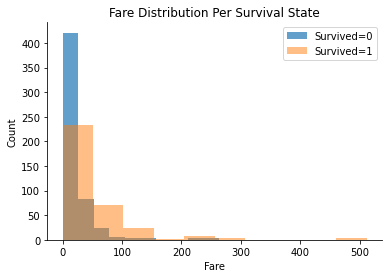

In [62]:
survived_fare = train_data[train_data['Survived']==1]['Fare']
NOsurvived_fare = train_data[train_data['Survived']==0]['Fare']

plt.hist(NOsurvived_fare, label = 'Survived=0', alpha=0.7);
plt.hist(survived_fare, label = 'Survived=1', alpha=0.5);
plt.legend();
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Fare')
plt.ylabel('Count')
plt.title('Fare Distribution Per Survival State');

### What is the relation between Fare and Class?

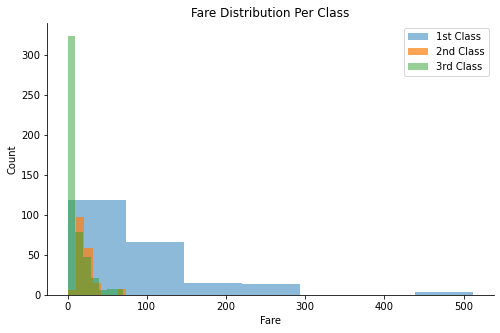

In [63]:
class1_fare = train_data[train_data['Pclass']=='1']['Fare']
class2_fare = train_data[train_data['Pclass']=='2']['Fare']
class3_fare = train_data[train_data['Pclass']=='3']['Fare']

plt.figure(figsize=(8,5))
plt.hist(class1_fare, label = '1st Class', alpha=0.5,bins=7,histtype='stepfilled');
plt.hist(class2_fare, label = '2nd Class', alpha=0.7,bins=7,histtype='stepfilled');
plt.hist(class3_fare, label = '3rd Class', alpha=0.5,bins=7,histtype='stepfilled');

plt.legend()
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Fare')
plt.ylabel('Count')
plt.title('Fare Distribution Per Class');

## Name - Title Vs Survival

In [64]:
train_data['passenger_title'] = train_data.Name.apply(lambda x: x.split(',',1)[1].split('.')[0].strip()).values

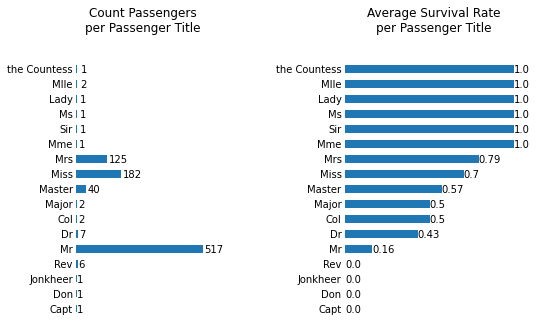

In [83]:
analyses_df = variable_mean_survival_sorted_survival('passenger_title')
unique_title = list(analyses_df.index)
title_value_count = list(analyses_df['countPerVarValue'])
avg_survival = list(analyses_df['avg_survival'])

plt.figure(figsize=(8,5))
gspec = gridspec.GridSpec(24, 50)


plot1 = plt.subplot(gspec[:, :15])
plot1.barh(unique_title, title_value_count, height = 0.5)
ax = plt.gca()
for spine in ax.spines:
    ax.spines[spine].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.get_xaxis().set_visible(False)  
plt.title('Count Passengers\nper Passenger Title\n');
for i, rect in enumerate(ax.patches):
    v =  rect.get_y()
    ax.text( v + rect.get_width(), i-.25 , str(rect.get_width()))
    
    
    
plot2 = plt.subplot(gspec[:, 30:]) 
   
plot2.barh(unique_title, avg_survival, height = 0.5)
ax = plt.gca()
for spine in ax.spines:
    ax.spines[spine].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.get_xaxis().set_visible(False)  
plt.title('Average Survival Rate\nper Passenger Title\n');
for i, rect in enumerate(ax.patches):
    v =  rect.get_y()
    width = rect.get_width()
    ax.text(rect.get_width() , i-.25 , str(round(width,2)))
#other than some titles being clearly related to 1st class, some titles apply to both 2nd and 3rd class   

### What is the relationshio between title and class?

In [160]:
copy_df = train_data[['PassengerId', 'passenger_title','Pclass']]

title_class_df = pd.DataFrame(train_data.groupby(['passenger_title','Pclass'])['PassengerId'].count()).rename(columns={'PassengerId':'Passengers_count'})
title_class_df['Passengers_count'] =  round(title_class_df['Passengers_count']/m*100,2)
title_class_df

Passengers_count
passenger_title Pclass                  
Capt            1                   0.11
Col             1                   0.22
Don             1                   0.11
Dr              1                   0.56
                2                   0.22
Jonkheer        1                   0.11
Lady            1                   0.11
Major           1                   0.22
Master          1                   0.34
                2                   1.01
                3                   3.14
Miss            1                   5.16
                2                   3.82
                3                  11.45
Mlle            1                   0.22
Mme             1                   0.11
Mr              1                  12.01
                2                  10.21
                3                  35.80
Mrs             1                   4.71
                2                   4.60
                3                   4.71
Ms              2                   0.11
Rev             2                   0.67
Sir             1                   0.11
the Countess    1                   0.11

In [176]:
class1 = title_class_df[title_class_df.index.get_level_values(1)=='1']
class2 = title_class_df[title_class_df.index.get_level_values(1)=='2']
class3 = title_class_df[title_class_df.index.get_level_values(1)=='3']
labels_titles = pd.DataFrame(labels_titles).rename(columns={0:'passenger_title'})
class1 = labels_titles.merge(class1, on ='passenger_title', how='left' )
class2 = labels_titles.merge(class2, on ='passenger_title', how='left' )
class3 = labels_titles.merge(class3, on ='passenger_title', how='left' )

In [177]:
labels_titles = list(title_class_df.index.get_level_values(0).unique())

In [181]:
class1['Passengers_count'].apply(lambda x:0 if pd.isnull(x) else x)

0      0.11
1      0.22
2      0.11
3      0.56
4      0.11
5      0.11
6      0.22
7      0.34
8      5.16
9      0.22
10     0.11
11    12.01
12     4.71
13     0.00
14     0.00
15     0.11
16     0.11
Name: Passengers_count, dtype: float64

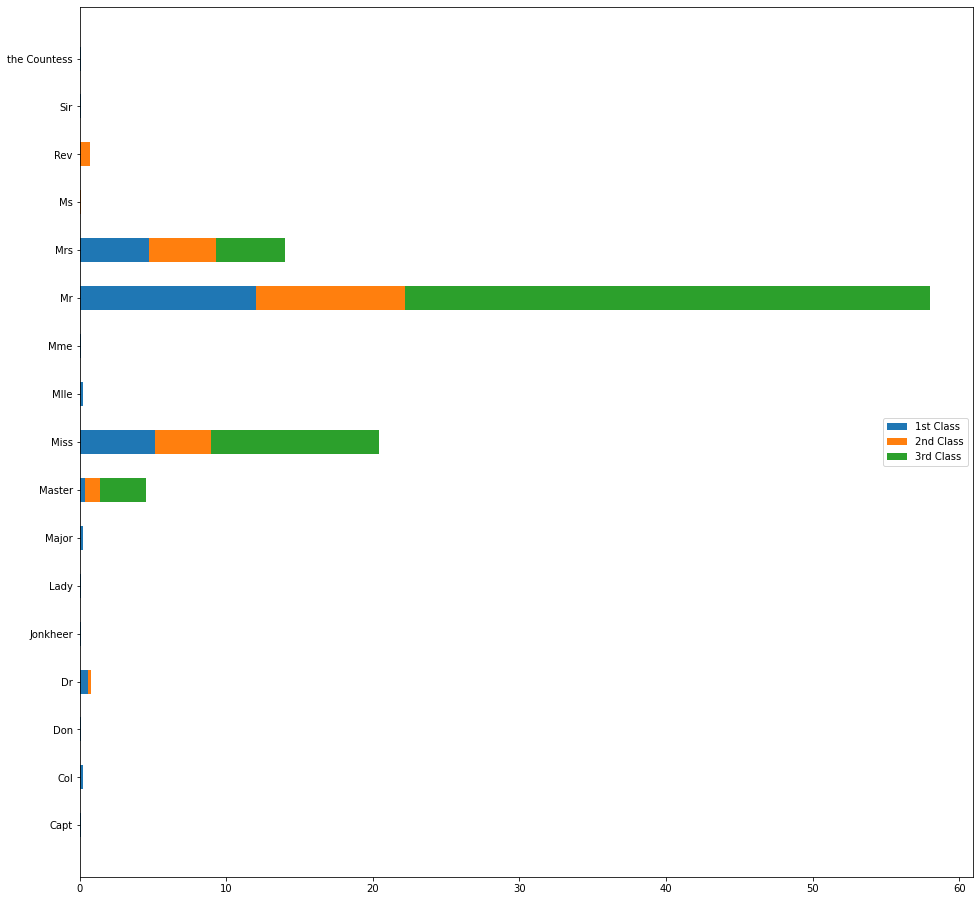

In [182]:
labels_titles = list(title_class_df.index.get_level_values(0).unique())
fig, ax = plt.subplots(figsize=(16,16))

ax.barh(labels_titles, class1['Passengers_count'], height = 0.5, label='1st Class')
ax.barh(labels_titles, class2['Passengers_count'], height = 0.5 , left = class1['Passengers_count'].apply(lambda x:0 if pd.isnull(x) else x), label='2nd Class')
ax.barh(labels_titles, class3['Passengers_count'], height = 0.5, left = (class1['Passengers_count'].apply(lambda x:0 if pd.isnull(x) else x)+class2['Passengers_count'].apply(lambda x:0 if pd.isnull(x) else x)) , label='3rd Class')
plt.legend();

### What is the relationship between Ticket and Survival?

- It looks like the Ticket is split into a prefix and a number sometimes and only numbers some other times.
- Followed strategy here is to split the prefix from the number and check their avergae survival rates 

In [66]:
train_data['Tckt_Pre'] = train_data['Ticket'].apply(lambda x: x.rsplit(' ',1)[0]  if len(x.rsplit(' ',1))>1 else np.nan)
train_data['Tckt_Pre'] = train_data['Tckt_Pre'].apply(lambda x: x if pd.isnull(x) else x.translate(str.maketrans('', '', string.punctuation)).replace(" ", ""))
train_data['Tckt_Num'] = train_data['Ticket'].apply(lambda x: x.rsplit(' ',1)[1]  if len(x.rsplit(' ',1))>1 else x.rsplit(' ',1)[0])
train_data['Tckt_Num'] = train_data['Tckt_Num'].apply(lambda x: x if pd.isnull(x) else x.translate(str.maketrans('', '', string.punctuation)))

### What is the relationship between ticket prefix and survival rates?

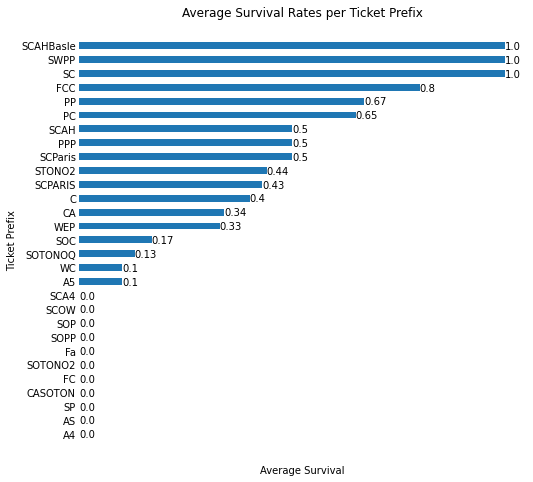

In [67]:
analyses_df = variable_mean_survival_sorted_survival('Tckt_Pre')
unique_TcktPre = list(analyses_df.index)
title_value_count = list(analyses_df['countPerVarValue'])
avg_survival = list(analyses_df['avg_survival'])

plt.figure(figsize=(8,8))
gspec = gridspec.GridSpec(24, 50)
plot1 = plt.subplot(gspec[:, :])

plot1.barh(unique_TcktPre, avg_survival, height = 0.5);

plt.title('Average Survival Rates per Ticket Prefix')
plt.ylabel('Ticket Prefix')
plt.xlabel('Average Survival')
ax = plt.gca()
for spine in ax.spines:
    ax.spines[spine].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_xticklabels([])
for i, rect in enumerate(ax.patches):
    v =  rect.get_y()
    ax.text(x=rect.get_width(),y=i-.25,s=str(rect.get_width()))

### What is the relationship between number of passengers on the same ticket and survival rates?

In [68]:
def get_cnt_tckt_passengers(col_val):
    ticket_passenger_cnt_df = pd.DataFrame(train_data.groupby('Ticket')['PassengerId'].count()).rename(columns={'PassengerId':'#Passengers'})
    tckt = col_val
    return ticket_passenger_cnt_df.loc[tckt]['#Passengers']

In [69]:
train_data['Tckt_Passengers_Cnt'] = train_data['Ticket'].apply(lambda x: get_cnt_tckt_passengers(x))
train_data['Tckt_MultiPassengers'] = train_data['Tckt_Passengers_Cnt'].apply(lambda x: 'Multi' if x>1 else 'Alone')

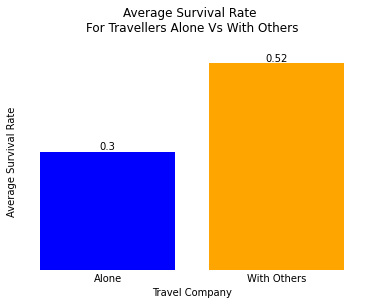

In [79]:
unique_value,unique_value_count, avg_survival,colors_map = variable_mean_survival('Tckt_MultiPassengers')
plt.bar(list(unique_value),avg_survival,color=colors_map)
plt_settings(plt,'Average Survival Rate \nFor Travellers Alone Vs With Others\n')
plt.xticks(ticks=[0,1], labels=['Alone', 'With Others']);
plt.ylabel('Average Survival Rate');
plt.xlabel('Travel Company');

At this point, we have two features indicating whether the passenger was travelling alone or with others:
- Family size based on Siblings, Spouses, Parents, and Children columns
- Number of passengers assigned to the same ticket  

Note that it was found that some passengers can be marked as travelling with others based on the Ticket column, but still have 0's in Siblings, Spouses, Parents, and Children columns. Therefore, a combination of both flags could prove useful.

# Dealing with Nulls and Missing values

In [71]:
titanic_train_data = train_data.copy()

### Embaked
has only 2 missing values, so they will be dropped

In [72]:
titanic_train_data.dropna(subset=['Embarked'],inplace = True)

### Age
- replace missing ages by avg age of passengers of the same class
- re-categorize passengers into Age Groups after filling missing values

In [73]:
def get_class_avgAge():
    return titanic_train_data.groupby('Pclass')['Age'].mean()

def derive_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    if pd.isnull(Age):
        return get_class_avgAge()[Pclass]
    else:
        return Age

titanic_train_data['Age'] = titanic_train_data[['Age','Pclass']].apply(derive_age,axis=1)  
titanic_train_data['Age'] = round(titanic_train_data['Age'], 2)

bins = [0, 2, 12, 17, 60, np.inf]
labels = ['baby', 'child', 'teenager', 'adult', 'elderly']
age_groups = pd.cut(titanic_train_data.Age, bins, labels = labels)
titanic_train_data['Age_Group'] = age_groups
titanic_train_data['Age_Group'] = titanic_train_data['Age_Group'].astype(str)

## Fare
replace missing fares wih avg class fare 

In [74]:
def get_class_avgFare():
    return titanic_train_data.groupby('Pclass')['Fare'].mean()
    
def derive_Fare(cols):
    Fare = cols[0]
    Pclass = cols[1]
    if pd.isnull(Fare):
        return get_class_avgFare()[Pclass]
    else:
        return Fare   
    
titanic_train_data['Fare'] = titanic_train_data[['Fare','Pclass']].apply(derive_Fare,axis=1)    

## Data types handling
turn categorical data and Flags into str instead of int

In [76]:
titanic_train_data.Pclass = titanic_train_data.Pclass.astype(str)
titanic_train_data.Survived = titanic_train_data.Survived.astype(str)

## Saving Processed Data

In [77]:
titanic_train_data.to_csv(processed_data_path, index=False)

## Conclusion

- Females Have higher chances of survival
- First class passengers have higher survival chances
- Most Passengers from Cherbourg station were first class so Cherbourg Passengers have higehr survival chances
- Younger people have higher chances of survival (i.e. babies, children, and teens)
- Passengers' travel company and sized has an impact on survival rates:
	- People travelling in small families (max of 4 siblings, spouses, children, and parents) had higher survival chances
	compared to people travelling alone or in larger groups
	- People travelling with other people generally ahd higher chances of survival
- Most people with unkown cabins are 3rd class passengers,so they have lower chnaces of survival.
- Some Cabin Categories seemed to provide better chances of survival 
	- Some of the categories are characterized by having 1st Class passengers 
- People who paid higher fares tend to have higher chances of survival as they are charazterized by being of higher class
- Some Titles are associated with higher survival rates
- Tickets have a prefix part and a numbe part. Some Ticket prefixes are associated with higher chances of survival.
Note: It was concluded that there is probably a relation between the ticket prefix and the departure station, but it could not be 100%% discerned		

Things looking into:
Titles as stacked bar chart by class
ticket prefix as stacked barchart per station